5.1  Register for a stream of Twitter data

5.2  Create a bloom filter classifying two days worth of twitters  ( after removing stop words and urls )

5.3  For another days worth of twitter data find the previous twitters that match in the bloom filter
(This means get two days of data in one file or directory , use that data for training the bloom filter, capture a different days data in a different file ( or do it in real time)and capture the match output then running the new twitter data through the filter.

5.4 Plot a historgram of matches for each twitter in 5.3

For the 4-5 grade.- Submit in a separate notebook - YourNAME-Homework5-Supplement

1. Use a different machine learning training algorithm
2. Make a continous feed where you take two days of data and match the incoming stream ( do this for 5 days windowing the filter data)
3. Find new trends in the twitter feed (daily or hourly)
4. Or some other streaming exploration of your choosing

In [1]:
%%writefile code/twitter_streaming_SA.py
# %load code/twitter_streaming_SA.py


#Import the necessary methods from tweepy library
from tweepy.streaming import StreamListener
import tweepy
from tweepy import OAuthHandler
from tweepy import Stream

#Variables that contains the user credentials to access Twitter API
access_token = "131711504-uteEX6y8zoi0v4miLzEjZefg22ZZ8TgukyU9bHYW"
access_token_secret = "UH3dk5s00euTgzJ92xveSSi7b84Aw2rrrtFeHelV5rmIv"
consumer_key = "7lKe94q4mhbeINgp1hFWmpdGj"
consumer_secret = "T46JL4SAhMK3EmiXpCFzSVwQ6ipvQ0xfqHBGbAUbPBVjtbDDp1"


#This is a basic listener that just prints received tweets to stdout.
class StdOutListener(StreamListener):        
    def on_data(self, data):
        print(data)
        return True

    def on_error(self, status):
        print(status)


if __name__ == '__main__':

    #This handles Twitter authetification and the connection to Twitter Streaming API
    l = StdOutListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    stream = Stream(auth, l)

    #This line filter Twitter Streams to capture data by the keywords: 'python', 'javascript', 'ruby'
    #stream.filter(track=['python', 'javascript', 'ruby'])
    stream.sample()

Overwriting code/twitter_streaming_SA.py


In [ ]:
%%sh  
python code/Twitter_streaming_SA.py > data/train.txt

### Cleaning train data (2 days data)

In [4]:
import json
import pandas as pd
tweets_data_path = 'data/training.txt'

tweets_data = []
tweets_file = open(tweets_data_path, "r")
for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue
        
print(len(tweets_data))

tweets = pd.DataFrame()
#tweets['text'] = list(map(lambda tweet: [tweet.get('text','') for tweet in tweets_data], tweets_data))
#tweets['lang'] = list(map(lambda tweet: tweet['lang'], tweets_data))
#tweets['time_zone'] = list(map(lambda tweet: tweet['user']['time_zone'], tweets_data))
#tweets['time_zone'] = [tweet.get('user', '').get('location', '') for tweet in tweets_data]

tweets['text'] = [tweet.get('text','') for tweet in tweets_data]
tweets['lang'] = [tweet.get('lang','') for tweet in tweets_data]
for tweet in tweets_data:
    if 'user' in tweet:
        tweets['time_zone'] = tweet['user']['location']
    else:
        tweets['time_zone'] = ""

tweets_by_lang = tweets['lang'].value_counts()
#tweets

81315


In [5]:
tweets.head()

,text,lang,time_zone
0,"RT @html_css_dev: React, Redux, &amp; Enzyme -...",en,"orlando, florida"
1,RT @learn_html_css_: How To Get 300 Real Follo...,en,"orlando, florida"
2,RT @jQuery_Aiden: Getting Started with jQuery ...,en,"orlando, florida"
3,RT @PrasanRecruiter: #Hiring #JavaScript Devel...,en,"orlando, florida"
4,😅 \nhttps://t.co/k0YVWL3JRv,und,"orlando, florida"


#### Removing urls from text of tweets

In [8]:
def remove_link(text):
    regex = r'https?://[^\s<>"]+|www\.[^\s<>"]+'
    return re.sub(regex, "", text)
    
# Remove urls from tweets text
#tweets['text']
train = pd.DataFrame()
train['text'] = tweets['text']
train['lang'] = tweets['lang']
train['text'] = list(train['text'].apply(lambda tweet: remove_link(tweet)))
train.head()

,text,lang
0,"RT @html_css_dev: React, Redux, &amp; Enzyme -...",en
1,RT @learn_html_css_: How To Get 300 Real Follo...,en
2,RT @jQuery_Aiden: Getting Started with jQuery ...,en
3,RT @PrasanRecruiter: #Hiring #JavaScript Devel...,en
4,😅 \n,und


#### Tokenize and remove stopwords

In [9]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sravanthi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sravanthi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.tokenize import word_tokenize
train['new_text'] = train['text'].apply(word_tokenize)
train['new_text'] = train['new_text'].apply(lambda x: [item for item in x if item not in stop])
train.head()

,text,lang,new_text
0,"RT @html_css_dev: React, Redux, &amp; Enzyme -...",en,"[RT, @, html_css_dev, :, React, ,, Redux, ,, &..."
1,RT @learn_html_css_: How To Get 300 Real Follo...,en,"[RT, @, learn_html_css_, :, How, To, Get, 300,..."
2,RT @jQuery_Aiden: Getting Started with jQuery ...,en,"[RT, @, jQuery_Aiden, :, Getting, Started, jQu..."
3,RT @PrasanRecruiter: #Hiring #JavaScript Devel...,en,"[RT, @, PrasanRecruiter, :, #, Hiring, #, Java..."
4,😅 \n,und,[😅]


In [29]:
train.iloc[1,0]

'RT @learn_html_css_: How To Get 300 Real Followers For Instagram a Day\n☞ \n\n #html #css #javascript #wordpress https:…'

In [26]:
train.iloc[1,2]

['RT',
 '@',
 'learn_html_css_',
 ':',
 'How',
 'To',
 'Get',
 '300',
 'Real',
 'Followers',
 'For',
 'Instagram',
 'Day',
 '☞',
 '#',
 'html',
 '#',
 'css',
 '#',
 'javascript',
 '#',
 'wordpress',
 'https',
 ':',
 '…']

### Cleaning test data

In [31]:
import json
import pandas as pd
tweets_data_path = 'data/test.txt'

tweets_data = []
tweets_file = open(tweets_data_path, "r")
for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue
        
print(len(tweets_data))

tweets = pd.DataFrame()
tweets['text'] = list(map(lambda tweet: tweet['text'], tweets_data))
tweets['lang'] = list(map(lambda tweet: tweet['lang'], tweets_data))
tweets['time_zone'] = list(map(lambda tweet: tweet['user']['time_zone'], tweets_data))
tweets_by_lang = tweets['lang'].value_counts()
#tweets

54063


In [32]:
tweets.head()

,text,lang,time_zone
0,RT @importpython: Pipfile and Pipenv : t... ht...,de,Pacific Time (US & Canada)
1,@NickVorraso Did you check out @cloudboostio? ...,en,Pacific Time (US & Canada)
2,Water restrictions expressed as a #Python http...,en,Kyiv
3,Making an animated radial menu with #CSS3 and ...,en,None
4,Deep Concept Of Regular Expression In JavaScri...,en,None


#### Removing urls from text of tweets

In [35]:
def remove_link(text):
    regex = r'https?://[^\s<>"]+|www\.[^\s<>"]+'
    return re.sub(regex, "", text)
    
# Remove urls from tweets text
#tweets['text']
test = pd.DataFrame()
test['text'] = tweets['text']
test['lang'] = tweets['lang']
test['text'] = list(test['text'].apply(lambda tweet: remove_link(tweet)))
test.head()

,text,lang
0,RT @importpython: Pipfile and Pipenv : t... #...,de
1,@NickVorraso Did you check out @cloudboostio? ...,en
2,Water restrictions expressed as a #Python,en
3,Making an animated radial menu with #CSS3 and ...,en
4,Deep Concept Of Regular Expression In JavaScri...,en


#### Tokenize and remove stop words

In [36]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sravanthi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sravanthi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.tokenize import word_tokenize
test['new_text'] = test['text'].apply(word_tokenize)
test['new_text'] = test['new_text'].apply(lambda x: [item for item in x if item not in stop])
test.head()

,text,lang,new_text
0,RT @importpython: Pipfile and Pipenv : t... #...,de,"[RT, @, importpython, :, Pipfile, Pipenv, :, ...."
1,@NickVorraso Did you check out @cloudboostio? ...,en,"[@, NickVorraso, Did, check, @, cloudboostio, ..."
2,Water restrictions expressed as a #Python,en,"[Water, restrictions, expressed, #, Python]"
3,Making an animated radial menu with #CSS3 and ...,en,"[Making, animated, radial, menu, #, CSS3, #, J..."
4,Deep Concept Of Regular Expression In JavaScri...,en,"[Deep, Concept, Of, Regular, Expression, In, J..."


In [38]:
test.iloc[1,0]

"@NickVorraso Did you check out @cloudboostio? We're MongoDB with super-powers for JavaScript apps."

In [39]:
test.iloc[1,2]

['@',
 'NickVorraso',
 'Did',
 'check',
 '@',
 'cloudboostio',
 '?',
 'We',
 "'re",
 'MongoDB',
 'super-powers',
 'JavaScript',
 'apps',
 '.']

#### Creating and training a bloomfilter on train data
Tried installing pybloomfiltermmap3 but got 'mman.h' file error. Looking up online, I found this package 'dynamic_pybloom' package which has all the necessary modules.
https://github.com/srf5132/dynamic-pybloom/

In [42]:
from dynamic_pybloom import ScalableBloomFilter
sbf = ScalableBloomFilter(mode=ScalableBloomFilter.SMALL_SET_GROWTH)

for tweet_word in train['new_text']:
    sbf.add(tweet_word)

In [43]:
len(sbf)

41587

In [44]:
'RT @learn_html_css_: How To Get 300 Real Followers For Instagram a Day\n☞ \n\n #html #css #javascript #wordpress https:…' in sbf

False

In [45]:
['RT',
 '@',
 'learn_html_css_',
 ':',
 'How',
 'To',
 'Get',
 '300',
 'Real',
 'Followers',
 'For',
 'Instagram',
 'Day',
 '☞',
 '#',
 'html',
 '#',
 'css',
 '#',
 'javascript',
 '#',
 'wordpress',
 'https',
 ':',
 '…'] in sbf

True

#### Comparing train and test data to see the no of matches
Using the scalable bloomfilter with train data tweets, I checked if each tweet in test data matches with any in scalablebloomfilter. Used count variables 'match_count', 'notmatch_count' to get the count of matched and unmatched tweets.

In [66]:
match_count = 0
nomatch_count = 0
for tweet in test['new_text']:
    if tweet in sbf:
        match_count += 1
    else:
        nomatch_count += 1
    
print(match_count)
print(nomatch_count)

21438
32625


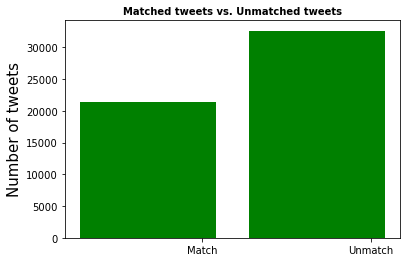

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
x_vars = ['Match', 'Unmatch']
x_pos = list(range(len(x_vars)))
y_pos = [match_count,nomatch_count]
width = 0.8
fig, ax = plt.subplots()
plt.bar(x_pos, y_pos, width, alpha=1, color='g')

# Setting axis labels and ticks
ax.set_ylabel('Number of tweets', fontsize=15)
ax.set_title('Matched tweets vs. Unmatched tweets', fontsize=10, fontweight='bold')
ax.set_xticks([p + 0.4 * width for p in x_pos])
ax.set_xticklabels(x_vars)
#plt.grid()

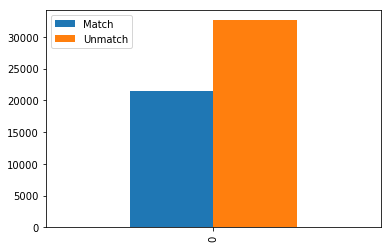

In [72]:
plt_tweets = pd.DataFrame()
plt_tweets['Match'] = [match_count]
plt_tweets['Unmatch'] = [nomatch_count]
plt_tweets.plot.bar()